In [37]:
from pymatgen import MPRester, Element, Composition
from pymatgen.phasediagram.analyzer import PhaseDiagram
from pymatgen.phasediagram.entries import PDEntry
from pymatgen.analysis.reaction_calculator import ComputedReaction
import matplotlib.pyplot as plt
import math
import scipy.constants as sc
import numpy as np

In [2]:
def high_temp_correction(e, temp, expt=False):
    '''Performs high-temp correction for the supplied entry, given the new temperature.'''
    entropies = dict(O2=(205.152/2), SO2=(248.223/3), SO3=(256.77/4), P2O5=(403.96/14), CO2=(213.795/3)) 
                    #gas phase entropy values
    pressures = dict(O2=0.2, SO2=10**-6, SO3=10**-6, P2O5=10**-8, CO2=0.04) #in atm
    s_e = entropies[e.name]/sc.N_A
    h_corr = 3.5*sc.k*(temp - 298)
    p_new = pressures[e.name]
    p_std = 1
    comp, factor = e.composition.get_reduced_composition_and_factor()
    na = e.composition.num_atoms/factor
    g500 = dict(O2=(h_corr- temp*s_e)*sc.N_A, SO2=-300.871, SO3=-352.668, CO2=-394.939, P2O5=-2507.262)
    g800 = dict(O2=(h_corr- temp*s_e)*sc.N_A, SO2=-298.370, SO3=-321.912, CO2=-395.586, P2O5=-2264.308)
    new_miu = ((h_corr - temp*s_e + sc.k*temp*math.log(p_new/p_std))/(na))/sc.e
    if expt: #only for 500 K and 800 K
        if temp == 500:
            new_miu = ((g500[e.name]/sc.N_A + sc.k*temp*math.log(p_new/p_std))/na)/sc.e
        if temp == 800:
            new_miu = ((g800[e.name]/sc.N_A + sc.k*temp*math.log(p_new/p_std))/na)/sc.e
    e.correction += new_miu*e.composition.num_atoms
    return new_miu

In [147]:
def get_chempots_phases_enthalpies(chsys, form, elem, temp=298, binary=None):
    chempots = [] #critical chemical potentials at every transition point
    evolutions = [] 
    phases = []
    enthalpies = []
    reactions = []
    yvec = []
    
    exclusion_list = ['LiS4','S8O']
    gas_phase_list = ['O2','CO2','SO2','SO3'] #remove O2 if you want to compare at 0
    gas_corr_dict = dict(O2=0, CO2=0, SO2=0, SO3=0) 
    
    if binary != None:
        entries, formula, compound = get_binary_entries(chsys, form, binary, elem, 0.5)
        
    else:
        formula = form
        with MPRester() as m:
            entries = m.get_entries_in_chemsys(chsys)
            mpentry = m.get_entries(formula) #gets all MP-entries associated with given composition

        pd = PhaseDiagram(entries) #initialize pd with all metastable entries

        if len(mpentry) == 0: #composition is metastable, so force it to lie on the convex hull
            compound = PDEntry(Composition(formula), 0)
            e0 = pd.get_e_above_hull(compound)
            compound = PDEntry(Composition(formula), -(e0*Composition(formula).num_atoms + 1e-8))
            entries.append(compound)
        else: #otherwise return the most stable entry in the list of MP-entries. This entry can be metastable.
                #in the future, may want to include a shift of "e-above-hull" to set this compound on the x-axis
            mpentry = sorted(mpentry, key=lambda e: e.energy_per_atom)
            compound = mpentry[0]
            entries.append(compound)
    
    #for high temp case, change e.correction of applicable entries
    if temp != 298:
        for e in entries:
            if e.name in gas_phase_list:
                corr = high_temp_correction(e, temp, expt=True)
                if gas_corr_dict[e.name] == 0:
                    gas_corr_dict[e.name] = corr
        print gas_corr_dict
    
    entries = [e for e in entries if e.name not in exclusion_list] 
    
    pd = PhaseDiagram(entries) #final pd with entries artificially shifted to hull
    evolution_profile = pd.get_element_profile(Element(elem), Composition(formula))
    ref = evolution_profile[0]['element_reference'].energy_per_atom
    
    reac = [compound, evolution_profile[0]['element_reference']]
    
    for stage in evolution_profile: #get chemical potentials and phases
        chempots.append(stage['chempot'] - ref)
        evolutions.append(stage['evolution'])
        namelist = []
        for entry in stage['entries']:
            namelist.append(entry.name)
        phases.append(namelist)
    
    yshift = 0  #initialize y-shift
    window = False #assume the compound has no stability window at first
    
    if binary == None:
        foo, factor = compound.composition.get_reduced_composition_and_factor()
        natoms = compound.composition.num_atoms/factor
    else:
        natoms = 0.5

    for stage in evolution_profile:
        rxn = ComputedReaction(reac, stage['entries']) #calculate reaction enthalpy
        rxn.normalize_to(Composition(formula)) #Composition(evolution_profile[0]['element_reference'].name)
        enthalpies.append(rxn.calculated_reaction_energy) #normalized per F.U. of material / per O2
        reactions.append(str(rxn)) #instead of normalizing to O2 just divide reaction by #O2 in reaction
        if abs(stage['evolution']) < 0.0001: #compound has a stability window
            window = True
#             if math.isnan(rxn.calculated_reaction_energy):
#                 yshift = 0
#             else:
            yshift = stage['evolution']*stage['chempot'] + rxn.calculated_reaction_energy
    
    target_H = None
    target_u = -1.133
    for i in range(len(chempots)): #manipulate and shift data for graphs
        #print chempots[i], enthalpies[i]
        ynew = ((evolutions[i]*(-chempots[i]) + enthalpies[i]) - yshift)/natoms #normalize to eV/atom
        yvec.append(ynew)
        enthalpies[i] = (enthalpies[i])/natoms #shift to normalize to eV/atom
        if chempots[i] < target_u and target_H == None: #find enthalpy at target chemical potential
            slope = (yvec[-1] - yvec[-2])/(chempots[i]-chempots[i-1])
            yint = yvec[-1] - slope*chempots[i]
            target_H = slope*target_u + yint
            print 'H at -1.133: ', target_H
#         if i == (len(chempots)-1):
#             slope = (yvec[-1] - yvec[-2])/(chempots[i]-chempots[i-1])
#             yint = yvec[-1] - slope*chempots[i]
#             bigH = slope*-6.2 + yint
#             print 'H at -6.2: ', bigH
    chempots_shifted = []
    for c in chempots:
        chempots_shifted.append(c + gas_corr_dict['O2']) 
    
    return [chempots, phases, yvec, enthalpies, reactions, chempots_shifted, target_H]

In [4]:
def get_binary_entries(chsys, formula1, formula2, elem, r):
    '''Provides the forumula and entries for a pseudo-binary with ratio r, given the compositions of the two
    constituent compounds.'''
    with MPRester() as m:
        entries = m.get_entries_in_chemsys(chsys)
        mpentries1 = m.get_entries(formula1)
        mpentries2 = m.get_entries(formula2)
        
    pd = PhaseDiagram(entries)
    
    #for each material, check if it exists in the database and return the most stable entry
    if len(mpentries1) != 0: #material exists in database
        mpentries1 = sorted(mpentries1, key=lambda e: e.energy_per_atom)
        m1 = mpentries1[0]
    else: #not in database, make one
        m1 = PDEntry(Composition(formula1), 0)
        e0 = pd.get_e_above_hull(m1)
        m1 = PDEntry(Composition(formula1), -(e0*Composition(formula1).num_atoms))
    entries.append(m1)
    
    if len(mpentries2) != 0:
        mpentries2 = sorted(mpentries2, key=lambda e: e.energy_per_atom)
        m2 = mpentries2[0]
    else:
        m2 = PDEntry(Composition(formula2), 0)
        e0 = pd.get_e_above_hull(m2)
        m2 = PDEntry(Composition(formula2), -(e0*Composition(formula2).num_atoms))
    entries.append(m2)
    
    m1C = Composition(m1.name)
    m2C = Composition(m2.name)
    
    E0 = m1.energy_per_atom * r + m2.energy_per_atom * (1 - r)
    comp = (1/m1C.num_atoms) * r * m1C + (1/m2C.num_atoms) * (1 - r) * m2C
    
    comp_entry = PDEntry(comp, (E0 + 1e-8))
    entries.append(comp_entry)
    
    return entries, comp, comp_entry

In [149]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.font_manager
import matplotlib.patches as patches

# mpl.rcdefaults()

f_size = 18
mpl.rcParams['xtick.labelsize']=f_size
mpl.rcParams['ytick.labelsize']=f_size
mpl.rcParams['axes.labelweight']='light'
mpl.rcParams['axes.labelsize']=f_size
mpl.rcParams['font.size']=f_size
mpl.rcParams['font.family']='sans-serif'
mpl.rcParams['font.sans-serif']='Arial'
mpl.rcParams['font.style']='normal'
mpl.rcParams['font.weight']='light'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'
mpl.rcParams["figure.figsize"] = (8,5)

import pandas as pnds
colo1='#107ab0'
colo2='#ff9408'
colo3='#4da409'

## Sulfide SSE

In [24]:
LPS = get_chempots_phases_enthalpies(['Li','P','S','O'],'Li3PS4','O')
Li2S = get_chempots_phases_enthalpies(['Li','S','O'],'Li2S','O')
LGS = get_chempots_phases_enthalpies(['Li','Ge','S','O'],'LiGeS4','O')
LPS1 = get_chempots_phases_enthalpies(['Li','P','S','O'],'Li7P3S11','O')
LPSCl = get_chempots_phases_enthalpies(['Li','P','S','Cl','O'],'Li6PS5Cl','O')
LPSI = get_chempots_phases_enthalpies(['Li','P','S','I','O'],'Li7P2S8I','O')
LGPS = get_chempots_phases_enthalpies(['Li','Ge','P','S','O'],'Li3.25Ge0.25P0.75S4','O')

Li3PS4
H at -1.133:  -3.02878598755
Li2S
H at -1.133:  -2.57784481333
Li3.5Zn0.25GeO4
H at -1.133:  2.3937924148e-15
LiGeS4
H at -1.133:  -2.98623622647
Li7P3S11
H at -1.133:  -3.09371444522
Li6PS5Cl
H at -1.133:  -2.53771472295
Li7P2S8I
H at -1.133:  -2.83119878338
Li3.25Ge0.25P0.75S4
H at -1.133:  -3.00714964572


In [132]:
LLZO = get_chempots_phases_enthalpies(['Li','La','Zr','O'],'Li7La3Zr2O12','O')
LISICON = get_chempots_phases_enthalpies(['Li','Zn','Ge','O'],'Li3.5Zn0.25GeO4','O')
LATP = get_chempots_phases_enthalpies(['Li','Al','Ti','P','O'],'Li1.3Al0.3Ti1.7P3O12','O')
LTP = get_chempots_phases_enthalpies(['Li','Ti','P','O'],'LiTi2P3O12','O')
LLTO = get_chempots_phases_enthalpies(['Li','La','Ti','P','O'],'Li0.33La0.56TiO3','O')
LAGP = get_chempots_phases_enthalpies(['Li','Al','Ge','P','O'],'Li1.5Al0.5Ge1.5P3O12','O')

H at -1.133:  1.16234455198e-15
H at -1.133:  2.33248695086e-15
H at -1.133:  -5.92264024646e-15
H at -1.133:  2.05372989656e-16
H at -1.133:  -0.00284302530501
H at -1.133:  5.24505501657e-16


In [152]:
pnds.options.display.float_format = '{:.3f}'.format
pnds.set_option('max_colwidth', 400)

table = pnds.DataFrame({r'$\mu_O$ (eV)':LPS[0],
                      'Phase Equilibria':LPS[1],
                    r'$\Delta H_{rxn}$ at $\mu_O$*':LPS[2],
                        'Reaction':LPS[4]})
display(table)

,$\Delta H_{rxn}$ at $\mu_O$*,$\mu_O$ (eV),Phase Equilibria,Reaction
0,-5.295,0.000,"[Li2S2O7, P2O5, SO3]",8 O2 + Li3PS4 -> SO3 + 1.5 Li2S2O7 + 0.5 P2O5
1,-1.753,-1.771,"[Li2S2O7, SO2, P2O5]",7.5 O2 + Li3PS4 -> SO2 + 1.5 Li2S2O7 + 0.5 P2O5
2,-1.300,-2.012,"[Li2S2O7, SO2, LiPO3]",7 O2 + Li3PS4 -> 2 SO2 + LiPO3 + Li2S2O7
3,-0.726,-2.341,"[SO2, Li2SO4, LiPO3]",6.5 O2 + Li3PS4 -> 3 SO2 + LiPO3 + Li2SO4
4,-0.313,-2.594,"[P2S7, Li2SO4, LiPO3]",3.125 O2 + Li3PS4 -> 0.25 LiPO3 + 1.375 Li2SO4 + 0.375 P2S7
5,-0.214,-2.722,"[Li4P2O7, Li2SO4, P2S7]",2.944 O2 + Li3PS4 -> 0.1111 Li4P2O7 + 1.278 Li2SO4 + 0.3889 P2S7
6,-0.151,-2.807,"[Li3PO4, P2S7, Li2SO4]",2.8 O2 + Li3PS4 -> 0.2 Li3PO4 + 1.2 Li2SO4 + 0.4 P2S7
7,0.000,-3.023,[Li3PS4],Li3PS4 -> Li3PS4


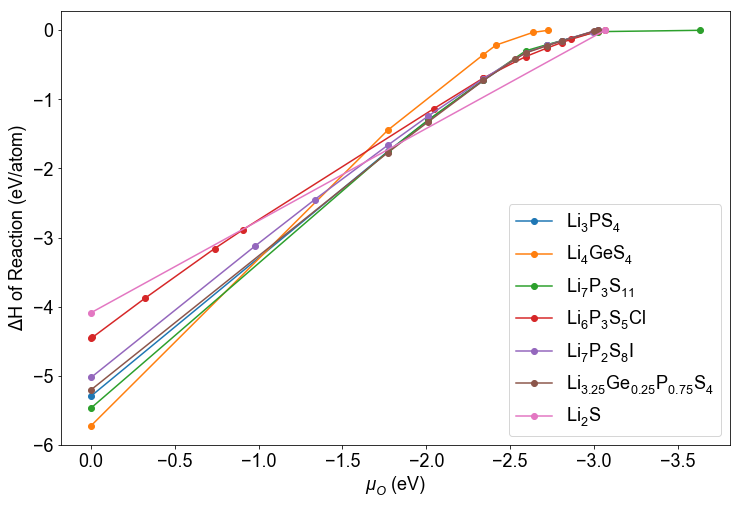

In [22]:
fig, ax = plt.subplots()

ax.set_ylabel(r'$\Delta$H of Reaction (eV/atom)')
ax.set_xlabel(r'$\mu_O$ (eV)')

p1 = plt.plot(LPS[0], LPS[2], 'o-', label= r'Li$_3$PS$_4$')
#p2 = plt.plot(LISICON[0], LISICON[2], 'o-', label= r'LISICON')
p3 = plt.plot(LGS[0], LGS[2], 'o-', label= r'Li$_4$GeS$_4$')
p4 = plt.plot(LPS1[0], LPS1[2], 'o-', label= r'Li$_7$P$_3$S$_{11}$')
p5 = plt.plot(LPSCl[0], LPSCl[2], 'o-', label= r'Li$_6$P$_3$S$_5$Cl')
p6 = plt.plot(LPSI[0], LPSI[2], 'o-', label= r'Li$_7$P$_2$S$_8$I')
p7 = plt.plot(LGPS[0], LGPS[2], 'o-', label= r'Li$_{3.25}$Ge$_{0.25}$P$_{0.75}$S$_4$')
p8 = plt.plot(Li2S[0], Li2S[2], 'o-', label= r'Li$_2$S')

legend = ax.legend(loc='lower right')

ax.invert_xaxis()
plt.show()

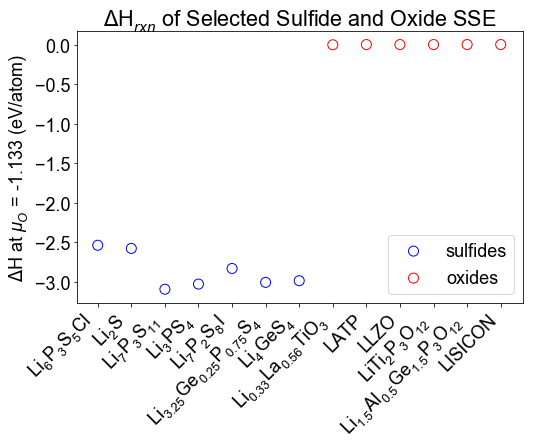

In [154]:
sulfides = dict([(r'Li$_3$PS$_4$', LPS[6]), 
             (r'Li$_4$GeS$_4$', LGS[6]), (r'Li$_7$P$_3$S$_{11}$', LPS1[6]),
             (r'Li$_6$P$_3$S$_5$Cl',LPSCl[6]), (r'Li$_7$P$_2$S$_8$I',LPSI[6]), 
             (r'Li$_{3.25}$Ge$_{0.25}$P$_{0.75}$S$_4$',LGPS[6]), (r'Li$_2$S', Li2S[6])])

oxides = dict([(r'LLZO', LLZO[6]), 
             (r'LiTi$_2$P$_3$O$_{12}$', LTP[6]), (r'LATP', LATP[6]),
             (r'LISICON',LISICON[6]), (r'Li$_{0.33}$La$_{0.56}$TiO$_3$', LLTO[6]),
               (r'Li$_{1.5}$Al$_{0.5}$Ge$_{1.5}$P$_3$O$_{12}$', LAGP[6])])

fig, ax = plt.subplots()
sulfn = list(sulfides.keys())
sulfv = list(sulfides.values())
oxidn = list(oxides.keys())
oxidv = list(oxides.values())
ssize = np.arange(0, len(sulfides), 1)
osize = np.arange(len(sulfides), len(sulfides)+len(oxides), 1)
xsize = np.arange(len(oxides)+len(sulfides))
p  = plt.scatter(ssize, sulfv, s=100, facecolors='none', edgecolors='b', label='sulfides')
p1 = plt.scatter(osize, oxidv, s=100, facecolors ='none', edgecolors='r', label='oxides')
ax.set_xticks(xsize)
ax.set_ylabel(r'$\Delta$H at $\mu_O$ = -1.133 (eV/atom)')

tikkos = ax.set_xticklabels(sulfn + oxidn, rotation=45, ha='right')
l = ax.legend(loc='lower right')
t = plt.title(r'$\Delta$H$_{rxn}$ of Selected Sulfide and Oxide SSE')

In [ ]:
sulfides = dict([(r'Li$_3$PS$_4$', LPS[0][0]), 
             (r'Li$_4$GeS$_4$', LGS[0][0]), (r'Li$_7$P$_3$S$_{11}$', LPS1[0][0]),
             (r'Li$_6$P$_3$S$_5$Cl',LPSCl[0][0]), (r'Li$_7$P$_2$S$_8$I',LPSI[0][0]), 
             (r'Li$_{3.25}$Ge$_{0.25}$P$_{0.75}$S$_4$',LGPS[6]), (r'Li$_2$S', Li2S[6])])

oxides = dict([(r'LLZO', LLZO[6]), 
             (r'LiTi$_2$P$_3$O$_{12}$', LTP[6]), (r'LATP', LATP[6]),
             (r'LISICON',LISICON[6]), (r'Li$_{0.33}$La$_{0.56}$TiO$_3$', LLTO[6]),
               (r'Li$_{1.5}$Al$_{0.5}$Ge$_{1.5}$P$_3$O$_{12}$', LAGP[6])])

fig, ax = plt.subplots()
sulfn = list(sulfides.keys())
sulfv = list(sulfides.values())
oxidn = list(oxides.keys())
oxidv = list(oxides.values())
ssize = np.arange(0, len(sulfides), 1)
osize = np.arange(len(sulfides), len(sulfides)+len(oxides), 1)
xsize = np.arange(len(oxides)+len(sulfides))
p  = plt.scatter(ssize, sulfv, s=100, facecolors='none', edgecolors='b', label='sulfides')
p1 = plt.scatter(osize, oxidv, s=100, facecolors ='none', edgecolors='r', label='oxides')
ax.set_xticks(xsize)
ax.set_ylabel(r'$\Delta$H at $\mu_O$ = -1.133 (eV/atom)')

tikkos = ax.set_xticklabels(sulfn + oxidn, rotation=45, ha='right')
l = ax.legend(loc='lower right')
t = plt.title(r'$\Delta$H$_{rxn}$ of Selected Sulfide and Oxide SSE')